In [1]:
# Yapılması gerekenler :1: test ve traini bir araya getirip tek bir df oluştur. Bu DF'den üzerine feature engineering yapılmayacak kısımları at
#                       2:bu tek df'de bütün feature engineering - aykırı değerleri temizle. Bunu şu yüzden yapıyoruz. temizlemeliyiz ki
#                         daha sonra modeli test seti ile etkileşime girip bağımlı değişkene bir şeyler atadığında aykırı değerlerden etkilenmesin 
#                        3: veri setlerini ayır. Train veri seti ile modeli eğit Test veri setini predict ettir.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#from catboost import CatBoostClassifier
# !pip install lightgbm
# !pip install xgboost
#from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action="ignore")
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

train_df = pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
df = [train_df,test_df]
df= pd.concat(df)
df.reset_index(drop=True, inplace=True)


In [1]:
len(train_df[df["ARTIS_DURUMU"].isin([1])]) / (len(train_df[df["ARTIS_DURUMU"].isin([1])])+len(train_df["ARTIS_DURUMU"]))    # Veri setinde bağımlı değişkenlerin 1 olma oranı

NameError: name 'train_df' is not defined

In [3]:
df.head()
df.tail()
train_df.head()
test_df.head()
test_df.columns  # Test DF'inde artıs durumu eksik. Bağımlı değişken haliyle.
train_df.columns

Index(['POLICY_ID', 'OFFICE_ID', 'SIGORTA_TIP', 'SOZLESME_KOKENI', 'SOZLESME_KOKENI_DETAY', 'BASLANGIC_TARIHI', 'KAPSAM_TIPI', 'KAPSAM_GRUBU', 'DAGITIM_KANALI',
       'POLICE_SEHIR', 'DOGUM_TARIHI', 'CINSIYET', 'UYRUK', 'MEMLEKET', 'MESLEK', 'MESLEK_KIRILIM', 'MUSTERI_SEGMENTI', 'YATIRIM_KARAKTERI', 'MEDENI_HAL',
       'EGITIM_DURUM', 'GELIR', 'COCUK_SAYISI', 'OCAK_ODENEN_TUTAR', 'OCAK_VADE_TUTARI', 'SUBAT_ODENEN_TU', 'SUBAT_VADE_TUTARI', 'MART_ODENEN_TUTAR', 'MART_VADE_TUTARI',
       'NISAN_ODENEN_TUTAR', 'NISAN_VADE_TUTARI', 'MAYIS_ODENEN_TUTAR', 'MAYIS_VADE_TUTARI', 'HAZIRAN_ODENEN_TUTAR', 'HAZIRAN_VADE_TUTARI', 'TEMMUZ_ODENEN_TUTAR',
       'TEMMUZ_VADE_TUTARI', 'AGUSTOS_ODENEN_TUTAR', 'AGUSTOS_VADE_TUTARI', 'EYLUL_ODENEN_TUTAR', 'EYLUL_VADE_TUTARI', 'EKIM_ODENEN_TUTAR', 'EKIM_VADE_TUTARI',
       'KASIM_ODENEN_TUTAR', 'KASIM_VADE_TUTARI', 'ARALIK_ODENEN_TUTAR', 'ARALIK_VADE_TUTARI', 'SENE_BASI_HESAP_DEGERI', 'SENE_SONU_HESAP_DEGERI', 'ARTIS_DURUMU'],
      dtype='object')

In [4]:
# GENEL RESİM'in incelenmesi
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df,2)

##################### Shape #####################
(877249, 49)
##################### Types #####################
POLICY_ID                   int64
OFFICE_ID                   int64
SIGORTA_TIP                 int64
SOZLESME_KOKENI            object
SOZLESME_KOKENI_DETAY      object
BASLANGIC_TARIHI           object
KAPSAM_TIPI                object
KAPSAM_GRUBU               object
DAGITIM_KANALI             object
POLICE_SEHIR               object
DOGUM_TARIHI                int64
CINSIYET                    int64
UYRUK                      object
MEMLEKET                    int64
MESLEK                     object
MESLEK_KIRILIM             object
MUSTERI_SEGMENTI          float64
YATIRIM_KARAKTERI          object
MEDENI_HAL                 object
EGITIM_DURUM               object
GELIR                      object
COCUK_SAYISI              float64
OCAK_ODENEN_TUTAR           int64
OCAK_VADE_TUTARI          float64
SUBAT_ODENEN_TU             int64
SUBAT_VADE_TUTARI         float64
MAR

In [5]:
#Gelir değişkenini nümerik , Başlangıç değişkenini Date haline getirme
df["GELIR"]= pd.to_numeric(df["GELIR"], errors='coerce')
df["BASLANGIC_TARIHI"] = pd.to_datetime(df["BASLANGIC_TARIHI"])



In [6]:
# Değişkenleri kategorik ve nümerik olarak ayırma
#Policy ID : İsim benzeri  olduğu için yok
#Artıs Durumu = Bağımlı Değişken olduğu için yok.


cat_cols =['OFFICE_ID','DOGUM_TARIHI','COCUK_SAYISI', 'SOZLESME_KOKENI', 'SOZLESME_KOKENI_DETAY', 'KAPSAM_GRUBU', 'DAGITIM_KANALI',
                 'YATIRIM_KARAKTERI', 'MEDENI_HAL', 'EGITIM_DURUM', 'SIGORTA_TIP', 'CINSIYET', 'MEMLEKET', 'MUSTERI_SEGMENTI', 'KAPSAM_TIPI',
                  'POLICE_SEHIR', 'UYRUK', 'MESLEK', 'MESLEK_KIRILIM']
num_cols = ['GELIR', 'OCAK_ODENEN_TUTAR', 'OCAK_VADE_TUTARI', 'SUBAT_ODENEN_TU', 'SUBAT_VADE_TUTARI', 'MART_ODENEN_TUTAR', 'MART_VADE_TUTARI',
                 'NISAN_ODENEN_TUTAR', 'NISAN_VADE_TUTARI', 'MAYIS_ODENEN_TUTAR', 'MAYIS_VADE_TUTARI', 'HAZIRAN_ODENEN_TUTAR','HAZIRAN_VADE_TUTARI',
                 'TEMMUZ_ODENEN_TUTAR', 'TEMMUZ_VADE_TUTARI', 'AGUSTOS_ODENEN_TUTAR', 'AGUSTOS_VADE_TUTARI', 'EYLUL_ODENEN_TUTAR', 'EYLUL_VADE_TUTARI',
                 'EKIM_ODENEN_TUTAR', 'EKIM_VADE_TUTARI', 'KASIM_ODENEN_TUTAR', 'KASIM_VADE_TUTARI', 'ARALIK_ODENEN_TUTAR', 'ARALIK_VADE_TUTARI', 'SENE_BASI_HESAP_DEGERI',
                 'SENE_SONU_HESAP_DEGERI']



In [7]:
##################################
# KATEGORİK DEĞİŞKENLERİN ANALİZİ
##################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)


       OFFICE_ID  Ratio
10006     236096 26.913
10017      39193  4.468
10023      14927  1.702
10091      11204  1.277
10029      11157  1.272
10117       8307  0.947
10301       4419  0.504
10234       4324  0.493
10099       3931  0.448
10073       3524  0.402
10093       3451  0.393
10018       3432  0.391
10043       3425  0.390
10044       3325  0.379
10022       2681  0.306
10238       2599  0.296
10085       2553  0.291
10359       2497  0.285
10421       2459  0.280
10037       2449  0.279
10127       2322  0.265
10213       2263  0.258
10126       2231  0.254
10047       2186  0.249
10009       2153  0.245
10054       2117  0.241
10034       2066  0.236
10284       2029  0.231
10162       2016  0.230
10315       1982  0.226
10134       1966  0.224
10264       1943  0.221
10400       1928  0.220
10214       1921  0.219
10240       1910  0.218
10510       1887  0.215
10089       1861  0.212
10035       1849  0.211
10038       1781  0.203
10453       1762  0.201
10036       1755

count            769676.000
mean          259884874.177
std        227969120856.273
min                  -3.000
5%                    0.000
10%                   0.000
20%                   1.000
30%                1000.000
40%                1500.000
50%                2000.000
60%                2500.000
70%                3000.000
80%                4000.000
90%                5000.000
95%               10000.000
99%               20000.000
max     200000000001500.000
Name: GELIR, dtype: float64


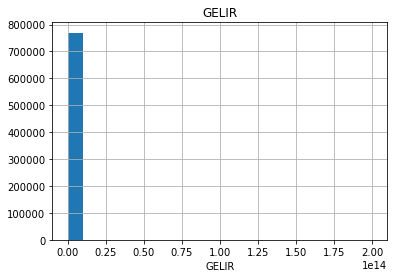

count   877249.000
mean       202.985
std        338.345
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        160.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1640.000
max      30000.000
Name: OCAK_ODENEN_TUTAR, dtype: float64


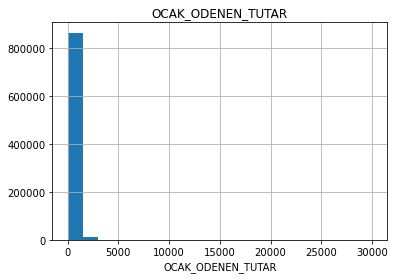

count   877249.000
mean       314.020
std        573.771
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        228.000
60%        270.000
70%        330.000
80%        340.000
90%        470.000
95%        720.000
99%       1790.000
max     300000.000
Name: OCAK_VADE_TUTARI, dtype: float64


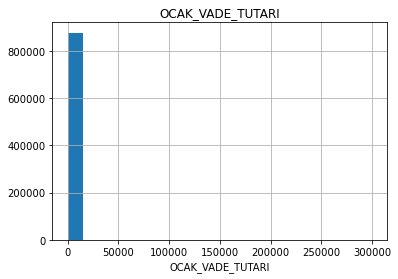

count   877249.000
mean       202.998
std        340.136
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        160.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1640.000
max      30000.000
Name: SUBAT_ODENEN_TU, dtype: float64


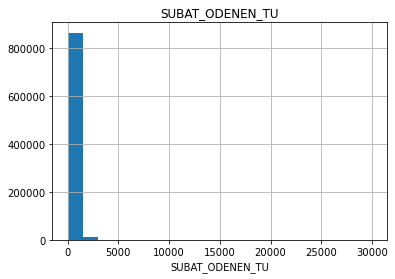

count   877249.000
mean       314.366
std        477.537
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        228.000
60%        270.000
70%        330.000
80%        340.000
90%        470.000
95%        723.708
99%       1810.000
max     295830.000
Name: SUBAT_VADE_TUTARI, dtype: float64


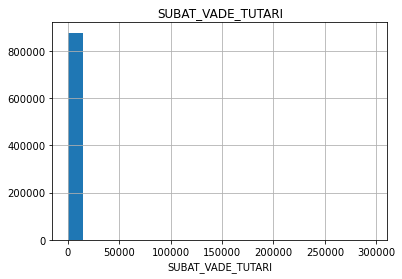

count   877249.000
mean       202.789
std        340.699
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        160.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1640.000
max      30000.000
Name: MART_ODENEN_TUTAR, dtype: float64


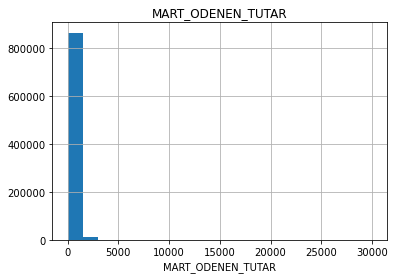

count   877249.000
mean       314.740
std        478.081
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        470.000
95%        730.000
99%       1820.000
max     295830.000
Name: MART_VADE_TUTARI, dtype: float64


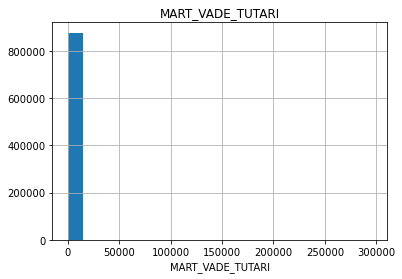

count   877249.000
mean       202.248
std        340.245
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1640.000
max      30000.000
Name: NISAN_ODENEN_TUTAR, dtype: float64


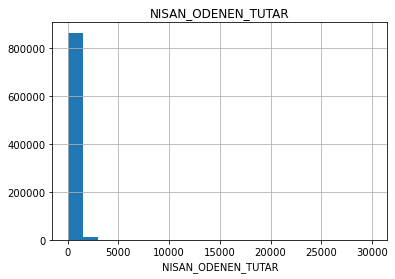

count   877249.000
mean       314.657
std        477.925
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        470.000
95%        729.872
99%       1810.000
max     295830.000
Name: NISAN_VADE_TUTARI, dtype: float64


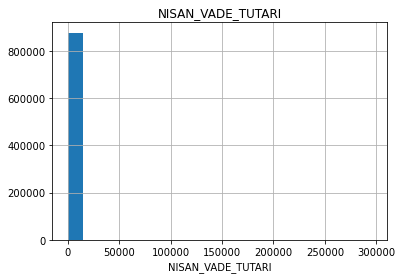

count   877249.000
mean       202.353
std        341.823
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1640.000
max      30000.000
Name: MAYIS_ODENEN_TUTAR, dtype: float64


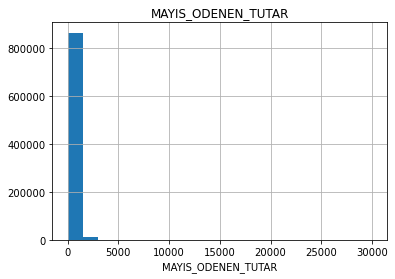

count   877249.000
mean       315.512
std        548.687
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        480.000
95%        730.000
99%       1840.000
max     295830.000
Name: MAYIS_VADE_TUTARI, dtype: float64


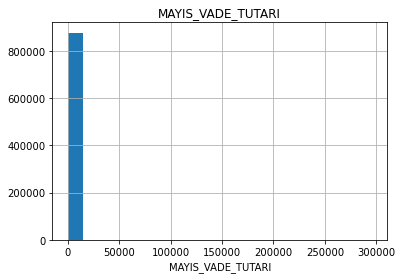

count   877249.000
mean       202.809
std        347.958
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1640.000
max      40000.000
Name: HAZIRAN_ODENEN_TUTAR, dtype: float64


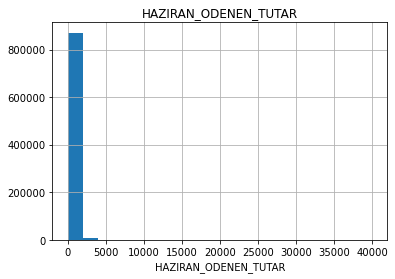

count   877249.000
mean       316.358
std        551.828
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        480.000
95%        730.000
99%       1860.000
max     295830.000
Name: HAZIRAN_VADE_TUTARI, dtype: float64


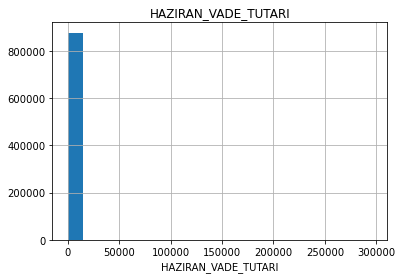

count   877249.000
mean       203.142
std        346.252
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        430.000
95%        670.000
99%       1653.120
max      40000.000
Name: TEMMUZ_ODENEN_TUTAR, dtype: float64


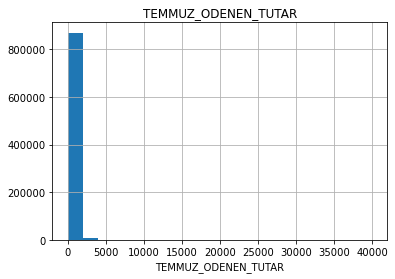

count   877249.000
mean       317.235
std        578.522
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        490.000
95%        750.000
99%       1900.000
max     300000.000
Name: TEMMUZ_VADE_TUTARI, dtype: float64


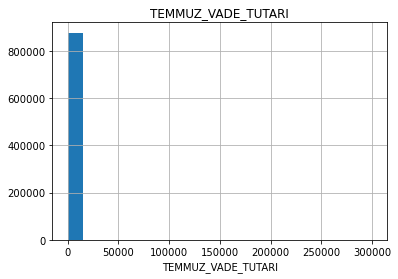

count   877249.000
mean       203.579
std        348.871
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        440.000
95%        680.000
99%       1660.000
max      40000.000
Name: AGUSTOS_ODENEN_TUTAR, dtype: float64


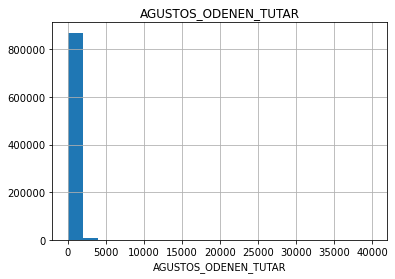

count   877249.000
mean       318.192
std        579.766
min         17.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        500.000
95%        750.000
99%       1922.000
max     300000.000
Name: AGUSTOS_VADE_TUTARI, dtype: float64


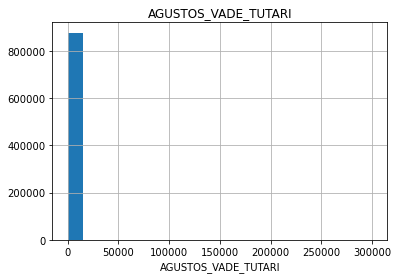

count   877249.000
mean       203.792
std        351.291
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        440.000
95%        680.000
99%       1660.000
max      45000.000
Name: EYLUL_ODENEN_TUTAR, dtype: float64


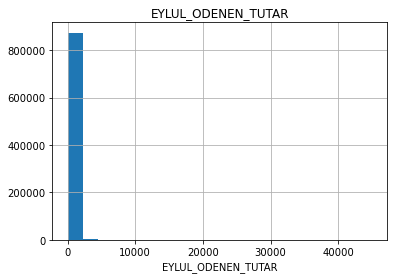

count    877249.000
mean        323.342
std        4117.901
min          17.000
5%          120.000
10%         150.000
20%         170.000
30%         190.000
40%         200.000
50%         230.000
60%         270.000
70%         330.000
80%         340.000
90%         500.000
95%         750.000
99%        1930.000
max     3818603.000
Name: EYLUL_VADE_TUTARI, dtype: float64


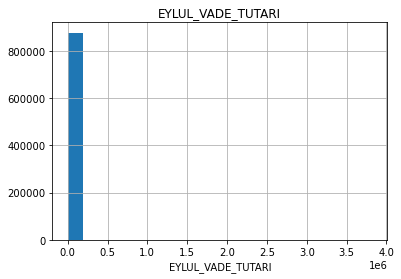

count   877249.000
mean       204.356
std        356.672
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        440.000
95%        680.000
99%       1660.000
max      45000.000
Name: EKIM_ODENEN_TUTAR, dtype: float64


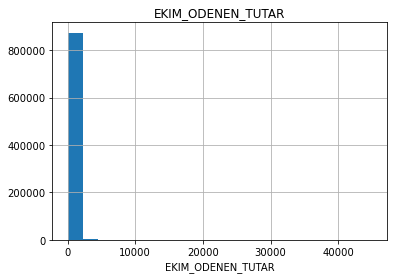

count   877249.000
mean       319.494
std        488.453
min         11.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        340.000
90%        500.000
95%        750.000
99%       1930.000
max     295830.000
Name: EKIM_VADE_TUTARI, dtype: float64


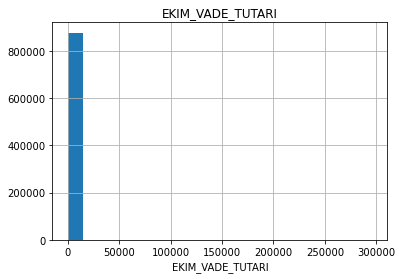

count   877249.000
mean       205.406
std        357.395
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        440.000
95%        680.000
99%       1700.000
max      45000.000
Name: KASIM_ODENEN_TUTAR, dtype: float64


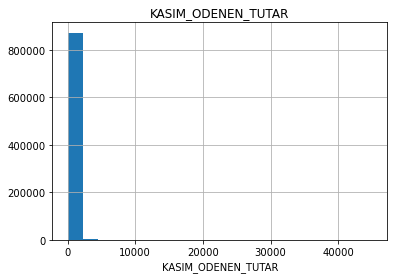

count   877249.000
mean       320.612
std        488.518
min         11.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        350.000
90%        500.000
95%        770.000
99%       1930.000
max     295830.000
Name: KASIM_VADE_TUTARI, dtype: float64


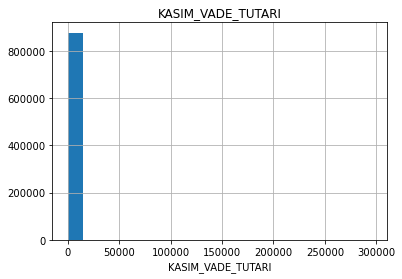

count   877249.000
mean       205.416
std        360.141
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        150.000
60%        200.000
70%        230.000
80%        300.000
90%        440.000
95%        690.000
99%       1700.000
max      45000.000
Name: ARALIK_ODENEN_TUTAR, dtype: float64


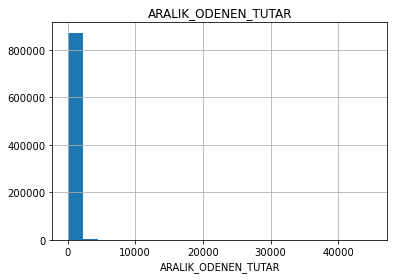

count   877249.000
mean       321.083
std        490.871
min          1.000
5%         120.000
10%        150.000
20%        170.000
30%        190.000
40%        200.000
50%        230.000
60%        270.000
70%        330.000
80%        350.000
90%        500.000
95%        770.000
99%       1930.000
max     295830.000
Name: ARALIK_VADE_TUTARI, dtype: float64


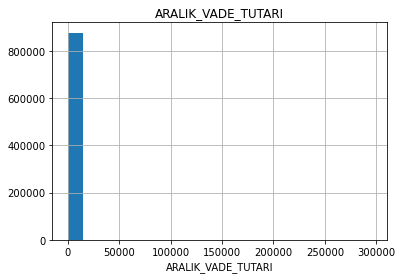

count    877249.000
mean      12328.855
std       28747.933
min        -336.910
5%            1.280
10%          56.058
20%         335.406
30%         899.644
40%        2017.704
50%        4004.570
60%        6630.288
70%        9983.254
80%       16506.810
90%       30424.764
95%       48099.992
99%      130887.795
max     3784299.670
Name: SENE_BASI_HESAP_DEGERI, dtype: float64


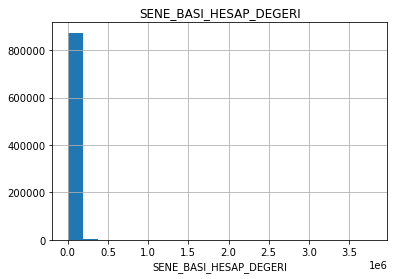

count    877249.000
mean      18232.161
std       40485.895
min         -88.990
5%            0.010
10%          49.750
20%         385.110
30%        1532.578
40%        3991.400
50%        7064.400
60%       10569.352
70%       15255.196
80%       24623.442
90%       44040.550
95%       69434.130
99%      186000.820
max     5006796.030
Name: SENE_SONU_HESAP_DEGERI, dtype: float64


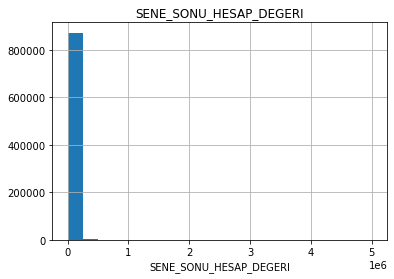

In [8]:

##################################
# NUMERİK DEĞİŞKENLERİN ANALİZİ
##################################
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)


In [9]:
#NÜMERİK DEĞİŞKENLERİN BAĞIMLI DEĞİŞKENE GÖRE  ANALİZİ

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "ARTIS_DURUMU", col)


                     GELIR
ARTIS_DURUMU              
0.000        393307608.012
1.000            17196.448


              OCAK_ODENEN_TUTAR
ARTIS_DURUMU                   
0.000                   183.625
1.000                   423.207


              OCAK_VADE_TUTARI
ARTIS_DURUMU                  
0.000                  304.089
1.000                  428.194


              SUBAT_ODENEN_TU
ARTIS_DURUMU                 
0.000                 183.251
1.000                 427.566


              SUBAT_VADE_TUTARI
ARTIS_DURUMU                   
0.000                   303.904
1.000                   432.712


              MART_ODENEN_TUTAR
ARTIS_DURUMU                   
0.000                   182.809
1.000                   429.928


              MART_VADE_TUTARI
ARTIS_DURUMU                  
0.000                  304.086
1.000                  435.158


              NISAN_ODENEN_TUTAR
ARTIS_DURUMU                    
0.000                    182.245
1.000                    42

In [10]:
##################################
# KATEGORİK DEĞİŞKENLERİN BAĞIMLI DEĞİŞKENE GÖRE  ANALİZİ
##################################

def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "ARTIS_DURUMU", col)

OFFICE_ID
       TARGET_MEAN   Count  Ratio
10000        0.056     166  0.019
10001        0.082      77  0.009
10002        0.108    1118  0.127
10003        0.060     203  0.023
10004        0.106    1406  0.160
10005        0.130     364  0.041
10006        0.085  236096 26.913
10007        0.079     379  0.043
10008        0.046     957  0.109
10009        0.081    2153  0.245
10010        0.031     290  0.033
10011        0.051     517  0.059
10012        0.075    1379  0.157
10013        0.066     307  0.035
10014        0.111     295  0.034
10015        0.073     530  0.060
10016        0.033     153  0.017
10017        0.039   39193  4.468
10018        0.065    3432  0.391
10019        0.132     600  0.068
10020        0.044     643  0.073
10021        0.069     546  0.062
10022        0.190    2681  0.306
10023        0.381   14927  1.702
10024        0.047     478  0.054
10025        0.075     319  0.036
10026        0.081     895  0.102
10027        0.051     908  0.104
1002

In [11]:

##################################
# EKSİK DEĞER ANALİZİ
##################################

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)



                       n_miss  ratio
YATIRIM_KARAKTERI      772684 88.080
ARTIS_DURUMU           243137 27.720
EGITIM_DURUM           207032 23.600
COCUK_SAYISI           163742 18.670
GELIR                  107573 12.260
MESLEK_KIRILIM          96432 10.990
MESLEK                  93249 10.630
SOZLESME_KOKENI_DETAY    8456  0.960
MEDENI_HAL               4479  0.510
POLICE_SEHIR             2508  0.290
UYRUK                     132  0.020
DAGITIM_KANALI              8  0.000
MUSTERI_SEGMENTI            5  0.000


In [12]:
#EKSİK DEĞERLERİN DOLDURULMASI


df["YATIRIM_KARAKTERI"]=df["YATIRIM_KARAKTERI"].fillna("cevaplanmamis")

#Egitim Durumu : Boş değerlerin bağımlı değişken başarısına oranı ilköğretim - liseye yakın olduğu için bu şekilde doldurduk. 
df["EGITIM_DURUM"]=df["EGITIM_DURUM"].fillna("Lise")

## En çok tekrarlanan değer 0 olduğu için 0 ile doldurduk.bağımlı değişken  ile ilişkisi de 0'a yakın.
df["COCUK_SAYISI"]=df["COCUK_SAYISI"].fillna(0)

## Gelir'i Outlier değerlerden etkilenmemek adına median'ı ile doldurduk.
df["GELIR"]=df["GELIR"].fillna(df["GELIR"].median())

## En çok tekrarlanan değer olan OCCU074 ile doldurduk.Bağımlı değişken ile olan ilişkisinin derecesi de buna yakın.
df["MESLEK_KIRILIM"]=df["MESLEK_KIRILIM"].fillna("OCCU074")

## En çok tekrarlanan değer olan  SEKT032 ile doldurduk. Eksik değerlerin bağımlı değişken ile ilişkisi 0.09  
#sekto32'nin 0.06 ancak bizim threshholdumuzdan düşük ikisi de dolayısıyla aynı sınıflandırmada olmalarında bir sakınca yok
df["MESLEK"]=df["MESLEK"].fillna("SEKT032")

#En çok tekrarlanan değer olan NEW ile doldurduk.
df["SOZLESME_KOKENI_DETAY"]=df["SOZLESME_KOKENI_DETAY"].fillna("NEW")


## En çok tekrarlanan değer olan Married ile doldurduk.
df["MEDENI_HAL"]=df["MEDENI_HAL"].fillna("Married")

## En çok tekrarlanan değer olan  İSTANBUL ile doldurduk.
df["POLICE_SEHIR"]=df["POLICE_SEHIR"].fillna("İSTANBUL")

## En çok tekrarlanan değer olan TR ile doldurduk.
df["UYRUK"]=df["UYRUK"].fillna("TR")


# en çok tekrarlanan değer olan Kanal4 + Kanal2 ile doldurduk.
df["DAGITIM_KANALI"]=df["DAGITIM_KANALI"].fillna("Kanal4 + Kanal2")


## En çok tekrarlanan değer olan 106.0 ile doldurduk.
df["MUSTERI_SEGMENTI"]=df["MUSTERI_SEGMENTI"].fillna(106.0)

#artıs durumu bağımlı değişken olduğu için kaldı.

df.isnull().sum()


POLICY_ID                      0
OFFICE_ID                      0
SIGORTA_TIP                    0
SOZLESME_KOKENI                0
SOZLESME_KOKENI_DETAY          0
BASLANGIC_TARIHI               0
KAPSAM_TIPI                    0
KAPSAM_GRUBU                   0
DAGITIM_KANALI                 0
POLICE_SEHIR                   0
DOGUM_TARIHI                   0
CINSIYET                       0
UYRUK                          0
MEMLEKET                       0
MESLEK                         0
MESLEK_KIRILIM                 0
MUSTERI_SEGMENTI               0
YATIRIM_KARAKTERI              0
MEDENI_HAL                     0
EGITIM_DURUM                   0
GELIR                          0
COCUK_SAYISI                   0
OCAK_ODENEN_TUTAR              0
OCAK_VADE_TUTARI               0
SUBAT_ODENEN_TU                0
SUBAT_VADE_TUTARI              0
MART_ODENEN_TUTAR              0
MART_VADE_TUTARI               0
NISAN_ODENEN_TUTAR             0
NISAN_VADE_TUTARI              0
MAYIS_ODEN

In [13]:
##################################
#NÜMERİK AYKIRI DEĞERLERİN TESPİT EDİLMESİ VE  THRESHOLDS İLE DEĞİŞTİRİLMESİ
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [14]:
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

GELIR True
OCAK_ODENEN_TUTAR True
OCAK_VADE_TUTARI True
SUBAT_ODENEN_TU True
SUBAT_VADE_TUTARI True
MART_ODENEN_TUTAR True
MART_VADE_TUTARI True
NISAN_ODENEN_TUTAR True
NISAN_VADE_TUTARI True
MAYIS_ODENEN_TUTAR True
MAYIS_VADE_TUTARI True
HAZIRAN_ODENEN_TUTAR True
HAZIRAN_VADE_TUTARI True
TEMMUZ_ODENEN_TUTAR True
TEMMUZ_VADE_TUTARI True
AGUSTOS_ODENEN_TUTAR True
AGUSTOS_VADE_TUTARI True
EYLUL_ODENEN_TUTAR True
EYLUL_VADE_TUTARI True
EKIM_ODENEN_TUTAR True
EKIM_VADE_TUTARI True
KASIM_ODENEN_TUTAR True
KASIM_VADE_TUTARI True
ARALIK_ODENEN_TUTAR True
ARALIK_VADE_TUTARI True
SENE_BASI_HESAP_DEGERI True
SENE_SONU_HESAP_DEGERI True


In [15]:
##################################
# FEATURE ENGINEERING
##################################


In [16]:
df.head()

,POLICY_ID,OFFICE_ID,SIGORTA_TIP,SOZLESME_KOKENI,SOZLESME_KOKENI_DETAY,BASLANGIC_TARIHI,KAPSAM_TIPI,KAPSAM_GRUBU,DAGITIM_KANALI,POLICE_SEHIR,DOGUM_TARIHI,CINSIYET,UYRUK,MEMLEKET,MESLEK,MESLEK_KIRILIM,MUSTERI_SEGMENTI,YATIRIM_KARAKTERI,MEDENI_HAL,EGITIM_DURUM,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU
0,7203428,10099,7,NEW,NEW,2014-04-01,PENSION318,STD B?REYSEL,Kanal7,ESK??EH?R,1964,2,TR,1,SEKT032,OCCU011,102.000,cevaplanmamis,Single,Lisans,2500.000,2.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,15248.750,25684.250,0.000
1,2857821,10100,7,NEW,NEW,2016-09-01,PENSION419,KATILIM STD B?REYSEL,Kanal4 + Kanal2,BALIKES?R,1966,1,TR,1,SEKT032,OCCU074,103.000,cevaplanmamis,Married,Lise,0.000,0.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,5842.710,10104.560,0.000
2,7833031,10042,1,NEW,NEW,2016-07-01,PENSION250,EV HANIMI,Kanal4 + Kanal2,BALIKES?R,1956,2,TR,1,SEKT032,OCCU074,106.000,cevaplanmamis,Married,Lise,0.000,0.000,280,280.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,3782.860,7060.940,0.000
3,4474944,10056,7,NEW,NEW,2014-09-01,PENSION434,KATILIM GRUP,Kanal4 + Kanal2,SAMSUN,1977,2,TR,1,SEKT032,OCCU039,102.000,cevaplanmamis,Married,Lisans,2500.000,0.000,130,130.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,6855.030,12645.250,0.000
4,4660085,10068,7,NEW,NEW,2008-04-01,PENSION100,STD GRUP,Kanal4 + Kanal2,?STANBUL,1962,2,TR,1,SEKT010,OCCU059,102.000,cevaplanmamis,Married,Lisans,5000.000,0.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,27837.750,31613.070,0.000


In [17]:
#veri seti içinde artış durumu değişkeninin gerçekleşme oranı 0.085
# Bizim aradığımız başarılı setler bunun ciddi oranda üzerinde başarıya sahip olanlar olmalı (Gözlem verileri incelemesi sonucu    olarak)
oran = 0.25
len(train_df[df["ARTIS_DURUMU"].isin([1])]) / len(train_df["ARTIS_DURUMU"])   

0.08695309345983045

In [18]:
#1 : office id
OFFICE_ID_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("OFFICE_ID")["ARTIS_DURUMU"].mean(),
                        "Count": df["OFFICE_ID"].value_counts(),
                        "Ratio": 100 * df["OFFICE_ID"].value_counts() / len(df)})
OFFICE_ID_INDEX = OFFICE_ID_DF[OFFICE_ID_DF["TARGET_MEAN"]>oran].index
df["OFFICE_ID_SUCC"] = df["OFFICE_ID"].apply(lambda x : 1 if x in OFFICE_ID_INDEX else 0)


In [19]:
#2 : sigorta tip
df["SIGORTA_TIP_SUCC"] = df["SIGORTA_TIP"].apply(lambda x : 1 if x in [6,7,8] else 0)


In [20]:
#3: Sözlesme kökeni
SOZLESME_KOKENI_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("SOZLESME_KOKENI")["ARTIS_DURUMU"].mean(),
                        "Count": df["SOZLESME_KOKENI"].value_counts(),
                        "Ratio": 100 * df["SOZLESME_KOKENI"].value_counts() / len(df)})
SOZLESME_KOKENI_INDEX = SOZLESME_KOKENI_DF[SOZLESME_KOKENI_DF["TARGET_MEAN"]>oran].index
df["SOZLESME_KOKENI_SUCC"] = df["SOZLESME_KOKENI"].apply(lambda x : 1 if x in SOZLESME_KOKENI_INDEX else 0)

In [21]:
#4: Sözlesme kökeni detay
SOZLESME_KOKENI_DETAY_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("SOZLESME_KOKENI_DETAY")["ARTIS_DURUMU"].mean(),
                        "Count": df["SOZLESME_KOKENI_DETAY"].value_counts(),
                        "Ratio": 100 * df["SOZLESME_KOKENI_DETAY"].value_counts() / len(df)})
SOZLESME_KOKENI_DETAY_INDEX = SOZLESME_KOKENI_DETAY_DF[SOZLESME_KOKENI_DETAY_DF["TARGET_MEAN"]>oran].index
df["SOZLESME_KOKENI_DETAY_SUCC"] = df["SOZLESME_KOKENI_DETAY"].apply(lambda x : 1 if x in SOZLESME_KOKENI_DETAY_INDEX else 0)

In [22]:
#5:Baslangıc Tarihi : #BASLANGIC TARİHİ DEĞİŞKENİNDEN SIRKETTE BULUNDUGU YIL DEĞİŞKENİNİ ÜRETİYORUZ
current_date = pd.to_datetime('2021-01-01 0:0:0')
df["BASLANGIC_TARIHI"] = (current_date - df["BASLANGIC_TARIHI"]).dt.days
df["SIRKETTEBULUNDUGUYIL"]= (df["BASLANGIC_TARIHI"]/365)
df.drop("BASLANGIC_TARIHI",axis=1,inplace=True)

In [23]:
#6: Kapsam Tipi
KAPSAM_TIPI_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("KAPSAM_TIPI")["ARTIS_DURUMU"].mean(),
                        "Count": df["KAPSAM_TIPI"].value_counts(),
                        "Ratio": 100 * df["KAPSAM_TIPI"].value_counts() / len(df)})

KAPSAM_TIPI_INDEX = KAPSAM_TIPI_DF[KAPSAM_TIPI_DF["TARGET_MEAN"]>oran].index
df["KAPSAM_TIPI_SUCC"] = df["KAPSAM_TIPI"].apply(lambda x : 1 if x in KAPSAM_TIPI_INDEX else 0)

In [24]:
#7: Kapsam Grubu
KAPSAM_GRUBU_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("KAPSAM_GRUBU")["ARTIS_DURUMU"].mean(),
                        "Count": df["KAPSAM_GRUBU"].value_counts(),
                        "Ratio": 100 * df["KAPSAM_GRUBU"].value_counts() / len(df)})
KAPSAM_GRUBU_INDEX = KAPSAM_GRUBU_DF[KAPSAM_GRUBU_DF["TARGET_MEAN"]>oran].index
df["KAPSAM_GRUBU_SUCC"] = df["KAPSAM_GRUBU"].apply(lambda x : 1 if x in KAPSAM_GRUBU_INDEX else 0)

In [25]:
#8:Dagıtım Kanalı
DAGITIM_KANALI_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("DAGITIM_KANALI")["ARTIS_DURUMU"].mean(),
                        "Count": df["DAGITIM_KANALI"].value_counts(),
                        "Ratio": 100 * df["DAGITIM_KANALI"].value_counts() / len(df)})
DAGITIM_KANALI_INDEX = DAGITIM_KANALI_DF[DAGITIM_KANALI_DF["TARGET_MEAN"]>oran].index
df["DAGITIM_KANALI_SUCC"] = df["DAGITIM_KANALI"].apply(lambda x : 1 if x in DAGITIM_KANALI_INDEX else 0)

In [26]:
#9:Police Sehir
POLICE_SEHIR_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("POLICE_SEHIR")["ARTIS_DURUMU"].mean(),
                        "Count": df["POLICE_SEHIR"].value_counts(),
                        "Ratio": 100 * df["POLICE_SEHIR"].value_counts() / len(df)})
POLICE_SEHIR_INDEX = POLICE_SEHIR_DF[POLICE_SEHIR_DF["TARGET_MEAN"]>oran].index
df["POLICE_SEHIR_SUCC"] = df["POLICE_SEHIR"].apply(lambda x : 1 if x in POLICE_SEHIR_INDEX else 0)

In [27]:
#10 Dogum Tarihi
#Dogum tarihi değişkenindeki yaşları çıkarıp Çocuk - GEnç - Orta - Yaşlı olarak sınıflandırdık.
df["YAS"]= 2021 - df["DOGUM_TARIHI"]
df.loc[(df['YAS'] <= 30), 'C_AGE_GROUPS'] = 'GENC'
df.loc[(df['YAS'] > 30) & (df['YAS'] < 50), 'C_AGE_GROUPS'] = 'ORTA'
df.loc[(df['YAS'] >= 50), 'C_AGE_GROUPS'] = 'YASLI'

#NOT : BUNUN SONUCLARI İLE BAĞIMLI DEĞ İNCELE.

#NOT 2: DOĞUM TARİHİNDEN YAŞ DEĞ ÇIKAR


In [28]:
#12 Uyruk
#bu işlem sonucunda bile saçma sapan bir sonuç verdi. atıyorum.


In [29]:
#13 Memleket
#bu işlem sonucunda bile saçma sapan bir sonuç verdi. atıyorum.


In [30]:
#14 Meslek
MESLEK_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("MESLEK")["ARTIS_DURUMU"].mean(),
                        "Count": df["MESLEK"].value_counts(),
                        "Ratio": 100 * df["MESLEK"].value_counts() / len(df)})
MESLEK_INDEX = MESLEK_DF[MESLEK_DF["TARGET_MEAN"]>oran].index
df["MESLEK_SUCC"] = df["MESLEK"].apply(lambda x : 1 if x in MESLEK_INDEX else 0)

In [31]:
#15 Meslek Kırılım
MESLEK_KIRILIM_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("MESLEK_KIRILIM")["ARTIS_DURUMU"].mean(),
                        "Count": df["MESLEK_KIRILIM"].value_counts(),
                        "Ratio": 100 * df["MESLEK_KIRILIM"].value_counts() / len(df)})

MESLEK_KIRILIM_INDEX = MESLEK_KIRILIM_DF[MESLEK_KIRILIM_DF["TARGET_MEAN"]>oran].index
df["MESLEK_KIRILIM_SUCC"] = df["MESLEK_KIRILIM"].apply(lambda x : 1 if x in MESLEK_KIRILIM_INDEX else 0)

In [32]:
#16 : Müşteri segmenti
MUSTERI_SEGMENTI_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("MUSTERI_SEGMENTI")["ARTIS_DURUMU"].mean(),
                        "Count": df["MUSTERI_SEGMENTI"].value_counts(),
                        "Ratio": 100 * df["MUSTERI_SEGMENTI"].value_counts() / len(df)})
MUSTERI_SEGMENTI_INDEX = MUSTERI_SEGMENTI_DF[MUSTERI_SEGMENTI_DF["TARGET_MEAN"]>oran].index
df["MUSTERI_SEGMENTI_SUCC"] = df["MUSTERI_SEGMENTI"].apply(lambda x : 1 if x in MUSTERI_SEGMENTI_INDEX else 0)

In [33]:
#17:medeni hal
MEDENI_HAL_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("MEDENI_HAL")["ARTIS_DURUMU"].mean(),
                        "Count": df["MEDENI_HAL"].value_counts(),
                        "Ratio": 100 * df["MEDENI_HAL"].value_counts() / len(df)})

MEDENI_HAL_INDEX = MEDENI_HAL_DF[MEDENI_HAL_DF["TARGET_MEAN"]>oran].index
df["MEDENI_HAL_SUCC"] = df["MEDENI_HAL"].apply(lambda x : 1 if x in MEDENI_HAL_INDEX else 0)

In [34]:
#18 egitim durum
EGITIM_DURUM_DF = pd.DataFrame({"TARGET_MEAN": df.groupby("EGITIM_DURUM")["ARTIS_DURUMU"].mean(),
                        "Count": df["EGITIM_DURUM"].value_counts(),
                        "Ratio": 100 * df["EGITIM_DURUM"].value_counts() / len(df)})
EGITIM_DURUM_INDEX = EGITIM_DURUM_DF[EGITIM_DURUM_DF["TARGET_MEAN"]>oran].index
df["EGITIM_DURUM_SUCC"] = df["EGITIM_DURUM"].apply(lambda x : 1 if x in EGITIM_DURUM_INDEX else 0)

In [35]:
#19 Gelir : Aynen kalacak

df["ANNUAL_TOTAL_PAID"]= (df['OCAK_ODENEN_TUTAR']+df['SUBAT_ODENEN_TU']+df['MART_ODENEN_TUTAR']+df['NISAN_ODENEN_TUTAR']+
                            df['MAYIS_ODENEN_TUTAR']+df['HAZIRAN_ODENEN_TUTAR']+df['TEMMUZ_ODENEN_TUTAR']+df['AGUSTOS_ODENEN_TUTAR']+
                            df['EYLUL_ODENEN_TUTAR']+df['EKIM_ODENEN_TUTAR']+df['KASIM_ODENEN_TUTAR']+df['ARALIK_ODENEN_TUTAR'])






df["PRIM_ODEDIKTEN_SONRA_GELIR"]= df["GELIR"]- df["ANNUAL_TOTAL_PAID"]




In [36]:
#FEATURE IMPORTANCE A GORE RATIOLAR
df["AYLIK_AV_PAID"] = df["ANNUAL_TOTAL_PAID"] / 12
df["YILLIK_ODEME_YAS_RATIO"]= df["ANNUAL_TOTAL_PAID"]/df["YAS"]
df["YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO"]= df["ANNUAL_TOTAL_PAID"]/df["SIRKETTEBULUNDUGUYIL"]

In [37]:
#yILLIK ödediği para / yaş 
df["YILLIK_ODEME_YAS_RATIO"]= df["ANNUAL_TOTAL_PAID"]/df["YAS"]
df["YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO"]= df["ANNUAL_TOTAL_PAID"]/df["YAS"]

In [38]:
#20 #Çocuk sayısı değişkenini çocuk sahibi olmayanlara 0 , çocuk sahibi olanlara 1 yazdırdık.
df["COCUK_SAYISI_SUCC"] = df["COCUK_SAYISI"].apply(lambda x : 0 if x == 0 else 1)

In [39]:
#21 OCAK - ARALIK ÖDENEN VE VADE TUTARLARI = BÜTÜN ÖDENEN TUTARLARIN TOPLAMI BÜTÜNÜ VADE TUTARINA EŞİTSE PAİD - DEĞİLSE LOW PAİD YA DA OVERPAİD TEK DEĞİŞKEN
df["ANNUAL_TOTAL_VADE"] =(df['OCAK_VADE_TUTARI']+df['SUBAT_VADE_TUTARI']+df['MART_VADE_TUTARI']+df['NISAN_VADE_TUTARI']+
                            df['MAYIS_VADE_TUTARI']+df['HAZIRAN_VADE_TUTARI']+df['TEMMUZ_VADE_TUTARI']+df['AGUSTOS_VADE_TUTARI']+
                            df['EYLUL_VADE_TUTARI']+df['EKIM_VADE_TUTARI']+df['KASIM_VADE_TUTARI']+df['ARALIK_VADE_TUTARI'])

df.loc[(df['ANNUAL_TOTAL_PAID'] == df["ANNUAL_TOTAL_VADE"]), 'ODEME_DURUMU'] = "PAID"
df.loc[(df['ANNUAL_TOTAL_PAID'] < df["ANNUAL_TOTAL_VADE"]), 'ODEME_DURUMU'] = "LOWPAID"
df.loc[(df['ANNUAL_TOTAL_PAID'] > df["ANNUAL_TOTAL_VADE"]), 'ODEME_DURUMU'] = "OVERPAID"




In [40]:
#22 SENE BAŞI HESAP- SENE SONU HESAP DEĞERİNDEN df["NOMINAL_RETURN"]  YAPILABİLŞİR . BU NOMİNAL RETURN GELİRE ORANLANABİLİR
df["NOMINAL_RETURN"] = df["SENE_SONU_HESAP_DEGERI"]-df["ANNUAL_TOTAL_PAID"]-df["SENE_BASI_HESAP_DEGERI"]


In [41]:
df.head()

,POLICY_ID,OFFICE_ID,SIGORTA_TIP,SOZLESME_KOKENI,SOZLESME_KOKENI_DETAY,KAPSAM_TIPI,KAPSAM_GRUBU,DAGITIM_KANALI,POLICE_SEHIR,DOGUM_TARIHI,CINSIYET,UYRUK,MEMLEKET,MESLEK,MESLEK_KIRILIM,MUSTERI_SEGMENTI,YATIRIM_KARAKTERI,MEDENI_HAL,EGITIM_DURUM,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU,OFFICE_ID_SUCC,SIGORTA_TIP_SUCC,SOZLESME_KOKENI_SUCC,SOZLESME_KOKENI_DETAY_SUCC,SIRKETTEBULUNDUGUYIL,KAPSAM_TIPI_SUCC,KAPSAM_GRUBU_SUCC,DAGITIM_KANALI_SUCC,POLICE_SEHIR_SUCC,YAS,C_AGE_GROUPS,MESLEK_SUCC,MESLEK_KIRILIM_SUCC,MUSTERI_SEGMENTI_SUCC,MEDENI_HAL_SUCC,EGITIM_DURUM_SUCC,ANNUAL_TOTAL_PAID,PRIM_ODEDIKTEN_SONRA_GELIR,AYLIK_AV_PAID,YILLIK_ODEME_YAS_RATIO,YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO,COCUK_SAYISI_SUCC,ANNUAL_TOTAL_VADE,ODEME_DURUMU,NOMINAL_RETURN
0,7203428,10099,7,NEW,NEW,PENSION318,STD B?REYSEL,Kanal7,ESK??EH?R,1964,2,TR,1,SEKT032,OCCU011,102.000,cevaplanmamis,Single,Lisans,2500.000,2.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,15248.750,25684.250,0.000,0,1,0,0,6.759,0,0,1,0,57,YASLI,0,0,0,0,0,2640,-140.000,220.000,46.316,46.316,1,2640.000,PAID,7795.500
1,2857821,10100,7,NEW,NEW,PENSION419,KATILIM STD B?REYSEL,Kanal4 + Kanal2,BALIKES?R,1966,1,TR,1,SEKT032,OCCU074,103.000,cevaplanmamis,Married,Lise,0.000,0.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,5842.710,10104.560,0.000,0,1,0,0,4.337,0,0,0,0,55,YASLI,0,0,0,0,0,1920,-1920.000,160.000,34.909,34.909,0,1920.000,PAID,2341.850
2,7833031,10042,1,NEW,NEW,PENSION250,EV HANIMI,Kanal4 + Kanal2,BALIKES?R,1956,2,TR,1,SEKT032,OCCU074,106.000,cevaplanmamis,Married,Lise,0.000,0.000,280,280.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,3782.860,7060.940,0.000,0,0,0,0,4.507,0,0,0,0,65,YASLI,0,0,0,0,0,3096,-3096.000,258.000,47.631,47.631,0,3096.000,PAID,182.080
3,4474944,10056,7,NEW,NEW,PENSION434,KATILIM GRUP,Kanal4 + Kanal2,SAMSUN,1977,2,TR,1,SEKT032,OCCU039,102.000,cevaplanmamis,Married,Lisans,2500.000,0.000,130,130.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,6855.030,12645.250,0.000,0,1,0,0,6.340,0,0,0,0,44,ORTA,0,0,0,0,0,1780,720.000,148.333,40.455,40.455,0,1780.000,PAID,4010.220
4,4660085,10068,7,NEW,NEW,PENSION100,STD GRUP,Kanal4 + Kanal2,?STANBUL,1962,2,TR,1,SEKT010,OCCU059,102.000,cevaplanmamis,Married,Lisans,5000.000,0.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,27837.750,31613.070,0.000,1,1,0,0,12.762,1,0,0,0,59,YASLI,0,0,0,0,0,1200,3800.000,100.000,20.339,20.339,0,1200.000,PAID,2575.320


In [42]:
new_cols= ["NOMINAL_RETURN","ANNUAL_TOTAL_VADE","PRIM_ODEDIKTEN_SONRA_GELIR","ANNUAL_TOTAL_PAID","YAS","SIRKETTEBULUNDUGUYIL","COCUK_SAYISI","YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO","YILLIK_ODEME_YAS_RATIO","AYLIK_AV_PAID"]

In [43]:
for col in new_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

NOMINAL_RETURN True
ANNUAL_TOTAL_VADE True
PRIM_ODEDIKTEN_SONRA_GELIR False
ANNUAL_TOTAL_PAID True
YAS False
SIRKETTEBULUNDUGUYIL False
COCUK_SAYISI True
YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO True
YILLIK_ODEME_YAS_RATIO True
AYLIK_AV_PAID True


In [44]:
df.head()

,POLICY_ID,OFFICE_ID,SIGORTA_TIP,SOZLESME_KOKENI,SOZLESME_KOKENI_DETAY,KAPSAM_TIPI,KAPSAM_GRUBU,DAGITIM_KANALI,POLICE_SEHIR,DOGUM_TARIHI,CINSIYET,UYRUK,MEMLEKET,MESLEK,MESLEK_KIRILIM,MUSTERI_SEGMENTI,YATIRIM_KARAKTERI,MEDENI_HAL,EGITIM_DURUM,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU,OFFICE_ID_SUCC,SIGORTA_TIP_SUCC,SOZLESME_KOKENI_SUCC,SOZLESME_KOKENI_DETAY_SUCC,SIRKETTEBULUNDUGUYIL,KAPSAM_TIPI_SUCC,KAPSAM_GRUBU_SUCC,DAGITIM_KANALI_SUCC,POLICE_SEHIR_SUCC,YAS,C_AGE_GROUPS,MESLEK_SUCC,MESLEK_KIRILIM_SUCC,MUSTERI_SEGMENTI_SUCC,MEDENI_HAL_SUCC,EGITIM_DURUM_SUCC,ANNUAL_TOTAL_PAID,PRIM_ODEDIKTEN_SONRA_GELIR,AYLIK_AV_PAID,YILLIK_ODEME_YAS_RATIO,YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO,COCUK_SAYISI_SUCC,ANNUAL_TOTAL_VADE,ODEME_DURUMU,NOMINAL_RETURN
0,7203428,10099,7,NEW,NEW,PENSION318,STD B?REYSEL,Kanal7,ESK??EH?R,1964,2,TR,1,SEKT032,OCCU011,102.000,cevaplanmamis,Single,Lisans,2500.000,0.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,15248.750,25684.250,0.000,0,1,0,0,6.759,0,0,1,0,57,YASLI,0,0,0,0,0,2640,-140.000,220.000,46.316,46.316,1,2640.000,PAID,7795.500
1,2857821,10100,7,NEW,NEW,PENSION419,KATILIM STD B?REYSEL,Kanal4 + Kanal2,BALIKES?R,1966,1,TR,1,SEKT032,OCCU074,103.000,cevaplanmamis,Married,Lise,0.000,0.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,5842.710,10104.560,0.000,0,1,0,0,4.337,0,0,0,0,55,YASLI,0,0,0,0,0,1920,-1920.000,160.000,34.909,34.909,0,1920.000,PAID,2341.850
2,7833031,10042,1,NEW,NEW,PENSION250,EV HANIMI,Kanal4 + Kanal2,BALIKES?R,1956,2,TR,1,SEKT032,OCCU074,106.000,cevaplanmamis,Married,Lise,0.000,0.000,280,280.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,3782.860,7060.940,0.000,0,0,0,0,4.507,0,0,0,0,65,YASLI,0,0,0,0,0,3096,-3096.000,258.000,47.631,47.631,0,3096.000,PAID,182.080
3,4474944,10056,7,NEW,NEW,PENSION434,KATILIM GRUP,Kanal4 + Kanal2,SAMSUN,1977,2,TR,1,SEKT032,OCCU039,102.000,cevaplanmamis,Married,Lisans,2500.000,0.000,130,130.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,6855.030,12645.250,0.000,0,1,0,0,6.340,0,0,0,0,44,ORTA,0,0,0,0,0,1780,720.000,148.333,40.455,40.455,0,1780.000,PAID,4010.220
4,4660085,10068,7,NEW,NEW,PENSION100,STD GRUP,Kanal4 + Kanal2,?STANBUL,1962,2,TR,1,SEKT010,OCCU059,102.000,cevaplanmamis,Married,Lisans,5000.000,0.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,27837.750,31613.070,0.000,1,1,0,0,12.762,1,0,0,0,59,YASLI,0,0,0,0,0,1200,3800.000,100.000,20.339,20.339,0,1200.000,PAID,2575.320


In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
POLICY_ID,877249.000,5494933.246,2593588.931,1000002.000,3246728.000,5497819.000,7743504.000,9989995.000
OFFICE_ID,877249.000,10330.703,393.168,10000.000,10006.000,10154.000,10558.000,11756.000
SIGORTA_TIP,877249.000,2.501,2.582,1.000,1.000,1.000,6.000,8.000
DOGUM_TARIHI,877249.000,1977.725,11.002,1921.000,1970.000,1978.000,1986.000,2004.000
CINSIYET,877249.000,1.516,0.500,1.000,1.000,2.000,2.000,2.000
MEMLEKET,877249.000,1.007,0.109,1.000,1.000,1.000,1.000,3.000
MUSTERI_SEGMENTI,877249.000,104.395,1.517,101.000,103.000,105.000,106.000,106.000
GELIR,877249.000,2557.581,3038.752,-3.000,1000.000,2000.000,3000.000,20000.000
COCUK_SAYISI,877249.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
OCAK_ODENEN_TUTAR,877249.000,195.453,280.730,0.000,0.000,160.000,270.000,1675.000


In [46]:
##################################
# ENCODING
##################################

# Değişkenlerin tiplerine göre ayrılması işlemi  
#-c age groups ve ödeme durumu one hot encoding'e sokulacak

In [47]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['SIGORTA_TIP',
 'SOZLESME_KOKENI',
 'SOZLESME_KOKENI_DETAY',
 'KAPSAM_GRUBU',
 'MEMLEKET',
 'MUSTERI_SEGMENTI',
 'YATIRIM_KARAKTERI',
 'MEDENI_HAL',
 'EGITIM_DURUM',
 'C_AGE_GROUPS',
 'ODEME_DURUMU']

In [48]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=True)
    return dataframe
df = one_hot_encoder(df, ohe_cols)


In [49]:
len(df.columns)

116

In [50]:
df.head()

,POLICY_ID,OFFICE_ID,KAPSAM_TIPI,DAGITIM_KANALI,POLICE_SEHIR,DOGUM_TARIHI,CINSIYET,UYRUK,MESLEK,MESLEK_KIRILIM,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU,OFFICE_ID_SUCC,SIGORTA_TIP_SUCC,SOZLESME_KOKENI_SUCC,SOZLESME_KOKENI_DETAY_SUCC,SIRKETTEBULUNDUGUYIL,KAPSAM_TIPI_SUCC,KAPSAM_GRUBU_SUCC,DAGITIM_KANALI_SUCC,POLICE_SEHIR_SUCC,YAS,MESLEK_SUCC,MESLEK_KIRILIM_SUCC,MUSTERI_SEGMENTI_SUCC,MEDENI_HAL_SUCC,EGITIM_DURUM_SUCC,ANNUAL_TOTAL_PAID,PRIM_ODEDIKTEN_SONRA_GELIR,AYLIK_AV_PAID,YILLIK_ODEME_YAS_RATIO,YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO,COCUK_SAYISI_SUCC,ANNUAL_TOTAL_VADE,NOMINAL_RETURN,SIGORTA_TIP_4,SIGORTA_TIP_6,SIGORTA_TIP_7,SIGORTA_TIP_8,SOZLESME_KOKENI_TRANS,SOZLESME_KOKENI_TRANS_C,SOZLESME_KOKENI_TRANS_L,SOZLESME_KOKENI_TRANS_TF,SOZLESME_KOKENI_DETAY_NEW,SOZLESME_KOKENI_DETAY_NEW_MRG,SOZLESME_KOKENI_DETAY_NEW_TR,SOZLESME_KOKENI_DETAY_TRANS,SOZLESME_KOKENI_DETAY_TRANS_C,SOZLESME_KOKENI_DETAY_TRANS_MRG,SOZLESME_KOKENI_DETAY_TRANS_T2,SOZLESME_KOKENI_DETAY_TRANS_TR,SOZLESME_KOKENI_DETAY_TR_T2_TR,KAPSAM_GRUBU_EV HANIMI,KAPSAM_GRUBU_GENÇ,KAPSAM_GRUBU_GRUP,KAPSAM_GRUBU_GRUPLANMAMI?,KAPSAM_GRUBU_KATILIM GRUP,KAPSAM_GRUBU_KATILIM STD B?REYSEL,KAPSAM_GRUBU_OKS,KAPSAM_GRUBU_STD B?REYSEL,KAPSAM_GRUBU_STD GRUP,MEMLEKET_2,MEMLEKET_3,MUSTERI_SEGMENTI_102.0,MUSTERI_SEGMENTI_103.0,MUSTERI_SEGMENTI_104.0,MUSTERI_SEGMENTI_105.0,MUSTERI_SEGMENTI_106.0,YATIRIM_KARAKTERI_Cesur,YATIRIM_KARAKTERI_Dengeli,YATIRIM_KARAKTERI_Dikkatli,YATIRIM_KARAKTERI_Temkinli,YATIRIM_KARAKTERI_Yetkin,YATIRIM_KARAKTERI_cevaplanmamis,MEDENI_HAL_Marriage Cancelled,MEDENI_HAL_Married,MEDENI_HAL_Other,MEDENI_HAL_Single,MEDENI_HAL_Widowed,EGITIM_DURUM_?lkö?retim,EGITIM_DURUM_Doktora,EGITIM_DURUM_Lisans,EGITIM_DURUM_Lise,EGITIM_DURUM_Yüksek Lisans,EGITIM_DURUM_Önlisans,C_AGE_GROUPS_ORTA,C_AGE_GROUPS_YASLI,ODEME_DURUMU_OVERPAID,ODEME_DURUMU_PAID
0,7203428,10099,PENSION318,Kanal7,ESK??EH?R,1964,2,TR,SEKT032,OCCU011,2500.000,0.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,15248.750,25684.250,0.000,0,1,0,0,6.759,0,0,1,0,57,0,0,0,0,0,2640,-140.000,220.000,46.316,46.316,1,2640.000,7795.500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1,2857821,10100,PENSION419,Kanal4 + Kanal2,BALIKES?R,1966,1,TR,SEKT032,OCCU074,0.000,0.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,5842.710,10104.560,0.000,0,1,0,0,4.337,0,0,0,0,55,0,0,0,0,0,1920,-1920.000,160.000,34.909,34.909,0,1920.000,2341.850,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
2,7833031,10042,PENSION250,Kanal4 + Kanal2,BALIKES?R,1956,2,TR,SEKT032,OCCU074,0.000,0.000,280,280.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,3782.860,7060.940,0.000,0,0,0,0,4.507,0,0,0,0,65,0,0,0,0,0,3096,-3096.000,258.000,47.631,47.631,0,3096.000,182.080,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,4474944,10056,PENSION434,Kanal4 + Kanal2,SAMSUN,1977,2,TR,SEKT032,OCCU039,2500.000,0.000,130,130.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,6855.030,12645.250,0.000,0,1,0,0,6.340,0,0,0,0,44,0,0,0,0,0,1780,720.000,148.333,40

In [51]:
df.drop("KAPSAM_TIPI",axis=1,inplace=True)

In [52]:
df.drop("DAGITIM_KANALI",axis=1,inplace=True)

In [53]:
df.drop("UYRUK",axis=1,inplace=True)

In [54]:
df.drop("MESLEK",axis=1,inplace=True)

In [55]:
df.drop("MESLEK_KIRILIM",axis=1,inplace=True)

In [56]:
df.drop("POLICE_SEHIR",axis=1,inplace=True)

In [57]:
df.head()

,POLICY_ID,OFFICE_ID,DOGUM_TARIHI,CINSIYET,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU,OFFICE_ID_SUCC,SIGORTA_TIP_SUCC,SOZLESME_KOKENI_SUCC,SOZLESME_KOKENI_DETAY_SUCC,SIRKETTEBULUNDUGUYIL,KAPSAM_TIPI_SUCC,KAPSAM_GRUBU_SUCC,DAGITIM_KANALI_SUCC,POLICE_SEHIR_SUCC,YAS,MESLEK_SUCC,MESLEK_KIRILIM_SUCC,MUSTERI_SEGMENTI_SUCC,MEDENI_HAL_SUCC,EGITIM_DURUM_SUCC,ANNUAL_TOTAL_PAID,PRIM_ODEDIKTEN_SONRA_GELIR,AYLIK_AV_PAID,YILLIK_ODEME_YAS_RATIO,YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO,COCUK_SAYISI_SUCC,ANNUAL_TOTAL_VADE,NOMINAL_RETURN,SIGORTA_TIP_4,SIGORTA_TIP_6,SIGORTA_TIP_7,SIGORTA_TIP_8,SOZLESME_KOKENI_TRANS,SOZLESME_KOKENI_TRANS_C,SOZLESME_KOKENI_TRANS_L,SOZLESME_KOKENI_TRANS_TF,SOZLESME_KOKENI_DETAY_NEW,SOZLESME_KOKENI_DETAY_NEW_MRG,SOZLESME_KOKENI_DETAY_NEW_TR,SOZLESME_KOKENI_DETAY_TRANS,SOZLESME_KOKENI_DETAY_TRANS_C,SOZLESME_KOKENI_DETAY_TRANS_MRG,SOZLESME_KOKENI_DETAY_TRANS_T2,SOZLESME_KOKENI_DETAY_TRANS_TR,SOZLESME_KOKENI_DETAY_TR_T2_TR,KAPSAM_GRUBU_EV HANIMI,KAPSAM_GRUBU_GENÇ,KAPSAM_GRUBU_GRUP,KAPSAM_GRUBU_GRUPLANMAMI?,KAPSAM_GRUBU_KATILIM GRUP,KAPSAM_GRUBU_KATILIM STD B?REYSEL,KAPSAM_GRUBU_OKS,KAPSAM_GRUBU_STD B?REYSEL,KAPSAM_GRUBU_STD GRUP,MEMLEKET_2,MEMLEKET_3,MUSTERI_SEGMENTI_102.0,MUSTERI_SEGMENTI_103.0,MUSTERI_SEGMENTI_104.0,MUSTERI_SEGMENTI_105.0,MUSTERI_SEGMENTI_106.0,YATIRIM_KARAKTERI_Cesur,YATIRIM_KARAKTERI_Dengeli,YATIRIM_KARAKTERI_Dikkatli,YATIRIM_KARAKTERI_Temkinli,YATIRIM_KARAKTERI_Yetkin,YATIRIM_KARAKTERI_cevaplanmamis,MEDENI_HAL_Marriage Cancelled,MEDENI_HAL_Married,MEDENI_HAL_Other,MEDENI_HAL_Single,MEDENI_HAL_Widowed,EGITIM_DURUM_?lkö?retim,EGITIM_DURUM_Doktora,EGITIM_DURUM_Lisans,EGITIM_DURUM_Lise,EGITIM_DURUM_Yüksek Lisans,EGITIM_DURUM_Önlisans,C_AGE_GROUPS_ORTA,C_AGE_GROUPS_YASLI,ODEME_DURUMU_OVERPAID,ODEME_DURUMU_PAID
0,7203428,10099,1964,2,2500.000,0.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,15248.750,25684.250,0.000,0,1,0,0,6.759,0,0,1,0,57,0,0,0,0,0,2640,-140.000,220.000,46.316,46.316,1,2640.000,7795.500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1,2857821,10100,1966,1,0.000,0.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,160,160.000,5842.710,10104.560,0.000,0,1,0,0,4.337,0,0,0,0,55,0,0,0,0,0,1920,-1920.000,160.000,34.909,34.909,0,1920.000,2341.850,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
2,7833031,10042,1956,2,0.000,0.000,280,280.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,256,256.000,3782.860,7060.940,0.000,0,0,0,0,4.507,0,0,0,0,65,0,0,0,0,0,3096,-3096.000,258.000,47.631,47.631,0,3096.000,182.080,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,4474944,10056,1977,2,2500.000,0.000,130,130.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,150,150.000,6855.030,12645.250,0.000,0,1,0,0,6.340,0,0,0,0,44,0,0,0,0,0,1780,720.000,148.333,40.455,40.455,0,1780.000,4010.220,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
4,4660085,10068,1962,2,5000.000,0.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,100.000,100,10

In [58]:
train = df.iloc[:634112,:]
test = df.iloc[634112:,:]

In [59]:
train.tail()


,POLICY_ID,OFFICE_ID,DOGUM_TARIHI,CINSIYET,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU,OFFICE_ID_SUCC,SIGORTA_TIP_SUCC,SOZLESME_KOKENI_SUCC,SOZLESME_KOKENI_DETAY_SUCC,SIRKETTEBULUNDUGUYIL,KAPSAM_TIPI_SUCC,KAPSAM_GRUBU_SUCC,DAGITIM_KANALI_SUCC,POLICE_SEHIR_SUCC,YAS,MESLEK_SUCC,MESLEK_KIRILIM_SUCC,MUSTERI_SEGMENTI_SUCC,MEDENI_HAL_SUCC,EGITIM_DURUM_SUCC,ANNUAL_TOTAL_PAID,PRIM_ODEDIKTEN_SONRA_GELIR,AYLIK_AV_PAID,YILLIK_ODEME_YAS_RATIO,YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO,COCUK_SAYISI_SUCC,ANNUAL_TOTAL_VADE,NOMINAL_RETURN,SIGORTA_TIP_4,SIGORTA_TIP_6,SIGORTA_TIP_7,SIGORTA_TIP_8,SOZLESME_KOKENI_TRANS,SOZLESME_KOKENI_TRANS_C,SOZLESME_KOKENI_TRANS_L,SOZLESME_KOKENI_TRANS_TF,SOZLESME_KOKENI_DETAY_NEW,SOZLESME_KOKENI_DETAY_NEW_MRG,SOZLESME_KOKENI_DETAY_NEW_TR,SOZLESME_KOKENI_DETAY_TRANS,SOZLESME_KOKENI_DETAY_TRANS_C,SOZLESME_KOKENI_DETAY_TRANS_MRG,SOZLESME_KOKENI_DETAY_TRANS_T2,SOZLESME_KOKENI_DETAY_TRANS_TR,SOZLESME_KOKENI_DETAY_TR_T2_TR,KAPSAM_GRUBU_EV HANIMI,KAPSAM_GRUBU_GENÇ,KAPSAM_GRUBU_GRUP,KAPSAM_GRUBU_GRUPLANMAMI?,KAPSAM_GRUBU_KATILIM GRUP,KAPSAM_GRUBU_KATILIM STD B?REYSEL,KAPSAM_GRUBU_OKS,KAPSAM_GRUBU_STD B?REYSEL,KAPSAM_GRUBU_STD GRUP,MEMLEKET_2,MEMLEKET_3,MUSTERI_SEGMENTI_102.0,MUSTERI_SEGMENTI_103.0,MUSTERI_SEGMENTI_104.0,MUSTERI_SEGMENTI_105.0,MUSTERI_SEGMENTI_106.0,YATIRIM_KARAKTERI_Cesur,YATIRIM_KARAKTERI_Dengeli,YATIRIM_KARAKTERI_Dikkatli,YATIRIM_KARAKTERI_Temkinli,YATIRIM_KARAKTERI_Yetkin,YATIRIM_KARAKTERI_cevaplanmamis,MEDENI_HAL_Marriage Cancelled,MEDENI_HAL_Married,MEDENI_HAL_Other,MEDENI_HAL_Single,MEDENI_HAL_Widowed,EGITIM_DURUM_?lkö?retim,EGITIM_DURUM_Doktora,EGITIM_DURUM_Lisans,EGITIM_DURUM_Lise,EGITIM_DURUM_Yüksek Lisans,EGITIM_DURUM_Önlisans,C_AGE_GROUPS_ORTA,C_AGE_GROUPS_YASLI,ODEME_DURUMU_OVERPAID,ODEME_DURUMU_PAID
634107,9328578,10773,1979,2,1000.000,0.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,480,480.000,31436.260,39605.590,0.000,0,0,0,0,8.759,0,0,0,0,42,0,0,0,0,0,5760,-4760.000,480.000,137.143,137.143,0,5760.000,2409.330,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1
634108,1037693,10591,1961,1,0.000,0.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,95,95.000,120248.060,173585.310,0.000,0,0,0,0,6.258,0,0,0,0,60,0,0,0,0,0,1140,-1140.000,95.000,19.000,19.000,0,1140.000,37433.709,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
634109,4285594,11422,1966,2,3000.000,0.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,0,287.000,20958.770,23038.390,0.000,0,0,0,0,7.844,0,0,0,0,55,0,0,0,0,0,0,3000.000,0.000,0.000,0.000,0,3444.000,2079.620,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
634110,5443282,10348,1988,2,2000.000,0.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,0,170.000,122.630,133.850,0.000,0,0,0,0,6.677,0,0,0,0,33,0,0,0,0,0,0,2000.000,0.000,0.000,0.000,0,2040.000,11.220,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
634111,6271932,10029,1974,2,500.000,0.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,0,270.000,59.570,63.840,0.000,0,0,0,0,6.090,0,0

In [60]:
test.head()



,POLICY_ID,OFFICE_ID,DOGUM_TARIHI,CINSIYET,GELIR,COCUK_SAYISI,OCAK_ODENEN_TUTAR,OCAK_VADE_TUTARI,SUBAT_ODENEN_TU,SUBAT_VADE_TUTARI,MART_ODENEN_TUTAR,MART_VADE_TUTARI,NISAN_ODENEN_TUTAR,NISAN_VADE_TUTARI,MAYIS_ODENEN_TUTAR,MAYIS_VADE_TUTARI,HAZIRAN_ODENEN_TUTAR,HAZIRAN_VADE_TUTARI,TEMMUZ_ODENEN_TUTAR,TEMMUZ_VADE_TUTARI,AGUSTOS_ODENEN_TUTAR,AGUSTOS_VADE_TUTARI,EYLUL_ODENEN_TUTAR,EYLUL_VADE_TUTARI,EKIM_ODENEN_TUTAR,EKIM_VADE_TUTARI,KASIM_ODENEN_TUTAR,KASIM_VADE_TUTARI,ARALIK_ODENEN_TUTAR,ARALIK_VADE_TUTARI,SENE_BASI_HESAP_DEGERI,SENE_SONU_HESAP_DEGERI,ARTIS_DURUMU,OFFICE_ID_SUCC,SIGORTA_TIP_SUCC,SOZLESME_KOKENI_SUCC,SOZLESME_KOKENI_DETAY_SUCC,SIRKETTEBULUNDUGUYIL,KAPSAM_TIPI_SUCC,KAPSAM_GRUBU_SUCC,DAGITIM_KANALI_SUCC,POLICE_SEHIR_SUCC,YAS,MESLEK_SUCC,MESLEK_KIRILIM_SUCC,MUSTERI_SEGMENTI_SUCC,MEDENI_HAL_SUCC,EGITIM_DURUM_SUCC,ANNUAL_TOTAL_PAID,PRIM_ODEDIKTEN_SONRA_GELIR,AYLIK_AV_PAID,YILLIK_ODEME_YAS_RATIO,YILLIK_ODEME_SIRKETTE_BULUNMA_RATIO,COCUK_SAYISI_SUCC,ANNUAL_TOTAL_VADE,NOMINAL_RETURN,SIGORTA_TIP_4,SIGORTA_TIP_6,SIGORTA_TIP_7,SIGORTA_TIP_8,SOZLESME_KOKENI_TRANS,SOZLESME_KOKENI_TRANS_C,SOZLESME_KOKENI_TRANS_L,SOZLESME_KOKENI_TRANS_TF,SOZLESME_KOKENI_DETAY_NEW,SOZLESME_KOKENI_DETAY_NEW_MRG,SOZLESME_KOKENI_DETAY_NEW_TR,SOZLESME_KOKENI_DETAY_TRANS,SOZLESME_KOKENI_DETAY_TRANS_C,SOZLESME_KOKENI_DETAY_TRANS_MRG,SOZLESME_KOKENI_DETAY_TRANS_T2,SOZLESME_KOKENI_DETAY_TRANS_TR,SOZLESME_KOKENI_DETAY_TR_T2_TR,KAPSAM_GRUBU_EV HANIMI,KAPSAM_GRUBU_GENÇ,KAPSAM_GRUBU_GRUP,KAPSAM_GRUBU_GRUPLANMAMI?,KAPSAM_GRUBU_KATILIM GRUP,KAPSAM_GRUBU_KATILIM STD B?REYSEL,KAPSAM_GRUBU_OKS,KAPSAM_GRUBU_STD B?REYSEL,KAPSAM_GRUBU_STD GRUP,MEMLEKET_2,MEMLEKET_3,MUSTERI_SEGMENTI_102.0,MUSTERI_SEGMENTI_103.0,MUSTERI_SEGMENTI_104.0,MUSTERI_SEGMENTI_105.0,MUSTERI_SEGMENTI_106.0,YATIRIM_KARAKTERI_Cesur,YATIRIM_KARAKTERI_Dengeli,YATIRIM_KARAKTERI_Dikkatli,YATIRIM_KARAKTERI_Temkinli,YATIRIM_KARAKTERI_Yetkin,YATIRIM_KARAKTERI_cevaplanmamis,MEDENI_HAL_Marriage Cancelled,MEDENI_HAL_Married,MEDENI_HAL_Other,MEDENI_HAL_Single,MEDENI_HAL_Widowed,EGITIM_DURUM_?lkö?retim,EGITIM_DURUM_Doktora,EGITIM_DURUM_Lisans,EGITIM_DURUM_Lise,EGITIM_DURUM_Yüksek Lisans,EGITIM_DURUM_Önlisans,C_AGE_GROUPS_ORTA,C_AGE_GROUPS_YASLI,ODEME_DURUMU_OVERPAID,ODEME_DURUMU_PAID
634112,6005558,10056,1966,2,2000.000,0.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,220,220.000,8903.840,14261.240,NaN,0,0,0,0,4.589,0,0,0,0,55,0,0,0,0,0,2640,-640.000,220.000,48.000,48.000,0,2640.000,2717.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1
634113,1227288,10006,1957,1,1.000,0.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,260,260.000,5373.670,8716.740,NaN,0,0,0,0,3.337,0,0,0,0,64,0,0,0,0,0,3120,-3119.000,260.000,48.750,48.750,0,3120.000,223.070,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
634114,5694750,10006,1955,1,5000.000,0.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,2782.680,6601.500,NaN,0,0,0,0,2.088,0,0,0,0,66,0,0,0,0,0,2520,2480.000,210.000,38.182,38.182,0,2520.000,1298.820,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1
634115,3150098,10006,1992,2,2500.000,0.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,210,210.000,1267.820,4428.120,NaN,0,0,0,0,1.507,0,0,0,0,29,0,0,0,0,0,2520,-20.000,210.000,86.897,86.897,0,2520.000,640.300,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
634116,4622228,10090,1980,1,2000.000,0.000,0,180.000,0,180.000,0,180.000,0,180.000,0,180.000,0,180.000,0,180.000,0,180.000,0,180.0

In [61]:
#MODEL KURMA

#Model Kurma
# Machine learning models require all input and output variables to be numeric. This means that if your data contains categorical data, you must encode it to numbers before you can fit and evaluate a model.
#DENEME - OPTİMİZASYON ( feature engineeringde en altta olanların atılması)





In [62]:
test.drop("ARTIS_DURUMU",axis=1,inplace=True)
test["ARTIS_DURUMU"] = ""



In [63]:
train_y = train["ARTIS_DURUMU"]
train_X = train.drop(["POLICY_ID","ARTIS_DURUMU"],axis=1)  
test_X = test.drop(["POLICY_ID","ARTIS_DURUMU"],axis=1)
test_y = test["ARTIS_DURUMU"]

In [64]:
rf_model = RandomForestClassifier(random_state=17).fit(train_X,train_y)
y_pred = rf_model.predict(test_X)

In [65]:
y_pred

array([0., 0., 0., ..., 1., 0., 0.])

In [66]:
y_pred = pd.DataFrame(y_pred, columns = ['ARTIS_DURUMU'])
test.reset_index(drop=True, inplace=True)
y_pred.reset_index(drop=True, inplace=True)
y_pred["POLICY_ID"] =test["POLICY_ID"]

In [ ]:
columns_titles = ["POLICY_ID","ARTIS_DURUMU"]
y_pred=y_pred.reindex(columns=columns_titles)
y_pred["ARTIS_DURUMU"]=y_pred["ARTIS_DURUMU"].astype(int)
y_pred.to_csv('30.csv',index=False)

In [63]:
y = train["ARTIS_DURUMU"]              # Bagımlı degisken tahmin etmeye calısıyorum
X = train.drop(["POLICY_ID","ARTIS_DURUMU"], axis=1)   #bagımsız degiskenler. bunu
rf_model = RandomForestClassifier(random_state=17).fit(X,y)

In [271]:
cv_results = cross_validate(rf_model, X, y, cv=2, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_roc_auc'].mean()
cv_results['test_f1'].mean()

0.3098156191046938

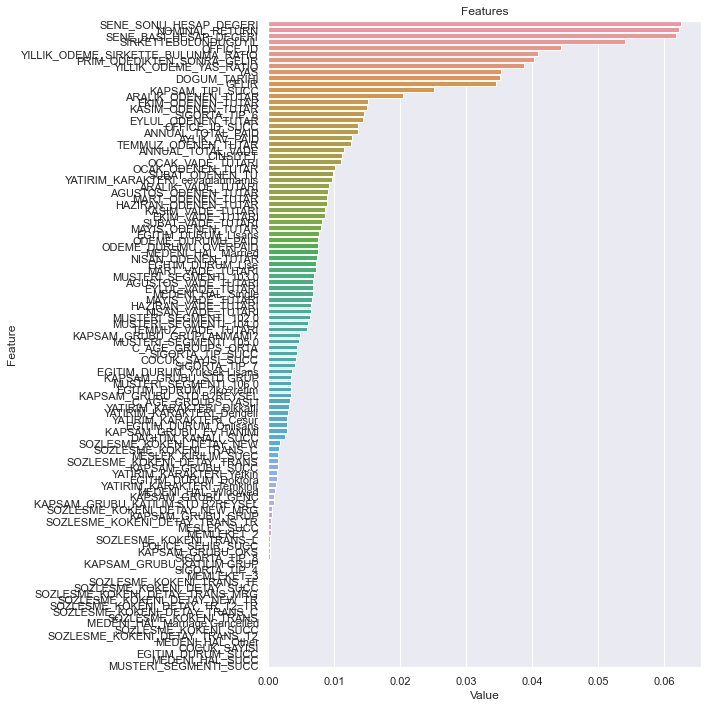

In [270]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)
#plot_importance(xgboost_final, X)
#plot_importance(lgbm_final, X)
#plot_importance(catboost_final, X)

In [591]:
#HİPERPARAMETRE OPTİMİZASYONU

In [ ]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

rf_final = rf_model.set_params(**rf_best_grid.bestparams, random_state=17).fit(X, y)

cv_results = cross_validate(rf_final, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_roc_auc'].mean()
cv_results['test_f1'].mean()


In [199]:
#SONUCU ALDIK. ŞİMDİ SONUÇ VE FEATURE İMPORTANCE'A GÖRE DEĞİŞKENLERİ AYARLAMA

feature_imp = pd.DataFrame({'Value': rf_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value")
feature_imp[feature_imp["Value"]<100]
drop_list = feature_imp["Feature"][0:20]
train.drop(drop_list,axis=1,inplace=True)               #TRAİNDEN DROPLADIK.
len(train.columns)

85

In [ ]:
# YARARLI KOD : Ay ve Yılı çıkarma.


def extract_month_year(df):
    assert "BASLANGIC_TARIHI" in df.columns
    
    datetime_obj = pd.to_datetime(df.BASLANGIC_TARIHI)
    df["baslangic_month"] = datetime_obj.dt.month
    df["baslangic_year"] = datetime_obj.dt.year


Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [ ]:
#Yararlı Kod 
def extract_tutar_stats(df, cols=[], groupname="None"):
    df[groupname + "_max"] = df[cols].max(axis=1)
    df[groupname + "_std"] = df[cols].std(axis=1)
    df[groupname + "_var"] = df[cols].var(axis=1)
    df[groupname + "_mad"] = df[cols].mad(axis=1)
    df[groupname + "_mean"] = df[cols].mean(axis=1)
    df[groupname + "_sum"] = df[cols].sum(axis=1)
    df[groupname + "_min"] = df[cols].min(axis=1)
    df[groupname + "_q05"] = df[cols].quantile(0.05, axis=1)
    df[groupname + "_q95"] = df[cols].quantile(0.95, axis=1)
    df[groupname + "_q25"] = df[cols].quantile(0.25, axis=1)
    df[groupname + "_q75"] = df[cols].quantile(0.75, axis=1)
    #     df[groupname+"_nunq"] = df[cols].nunique(axis=1)
    df[groupname + "_skew"] = df[cols].skew(axis=1)
    df[groupname + "_kurt"] = df[cols].kurt(axis=1)


In [ ]:
#Yararlı Kod : Farklı bir yaklaşım


    df["uyruk_memleket"] = df["UYRUK"].astype(str) + "_" + df["MEMLEKET"].astype(str)
    df["dogumtarihi_cinsiyet"] = (
        df["DOGUM_TARIHI"].astype(str) + "_" + df["CINSIYET"].astype(str)
    )
    df["meslek_medenihal_egitim"] = (
        df["MESLEK"].astype(str)
        + "_"
        + df["MEDENI_HAL"].astype(str)
        + "_"
        + df["EGITIM_DURUM"].astype(str)
    )
    df["dogumtarihi_meslek_medenihal"] = (
        df["DOGUM_TARIHI"].astype(str)
        + "_"
        + df["MESLEK"].astype(str)
        + "_"
        + df["MEDENI_HAL"].astype(str)
    )
    df["sigortatip_kapsamtipi"] = (
        df["SIGORTA_TIP"].astype(str) + "_" + df["KAPSAM_TIPI"].astype(str)
    )

    df["gelir_medenihal_egitim"] = (
        df["GELIR_qcut"].astype(str)
        + "_"
        + df["MEDENI_HAL"].astype(str)
        + "_"
        + df["EGITIM_DURUM"].astype(str)
    )

In [ ]:
#Yararlı Kod - TRİAL yapma Pipeline benzeri
import optuna

def objective(trial,data=X, target=y, model_name="XGBoost"):   
    if model_name == "XGBoost":
        params = {

        'learning_rate': trial.suggest_float(
                                        "learning_rate", 0.001, 0.2),

        'n_estimators': trial.suggest_int(
                                    'n_estimators', 200, 8000),

        "scale_pos_weight":  trial.suggest_float(
                                        "scale_pos_weight", 1, 10)
        }
        model =XGBClassifier(**params, random_state=42,tree_method="gpu_hist",
                                        gpu_id=0,
                                        predictor="gpu_predictor") 
        
    if model_name == "CatBoost":
        params = {
        'learning_rate': trial.suggest_float(
                                        "learning_rate", 0.001, 0.2),

        'n_estimators': trial.suggest_int(
                                    'n_estimators', 200, 8000),

        "scale_pos_weight":  trial.suggest_float(
                                        "scale_pos_weight", 1, 10)
   }
        model =CatBoostClassifier(**params, task_type="GPU",devices='0:1', verbose=0, random_state=42) 

    if model_name == "LGBM":
        params = {
        'learning_rate': trial.suggest_float(
                                        "learning_rate", 0.001, 0.2),

        'n_estimators': trial.suggest_int(
                                    'n_estimators', 200, 8000),

        "scale_pos_weight":  trial.suggest_float(
                                        "scale_pos_weight", 1, 10)

    }
        model =LGBMClassifier(**params,random_state=42)

    cv_score = train_and_validate(model_name, model, 5, data, target)
        
    return cv_score

TUNE = False
if TUNE:
    study = optuna.create_study(direction = 'maximize')
    study.optimize(objective, n_trials = 75)
    print('Best value:', study.best_value)
    optuna_params = study.best_params

In [ ]:
rf_gini_params = {'max_depth': 72, 'max_features': 'sqrt', 'n_estimators': 289, 'min_samples_split': 3, 'min_samples_leaf': 5, 'bootstrap': True, 'class_weight': 'balanced'}
rf_gini = RandomForestClassifier(**rf_gini_params, random_state=32)

rf_entropy_params = {'max_depth': 37, 'max_features': 'sqrt', 'n_estimators': 133, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'class_weight': 'balanced_subsample'}
rf_entropy = RandomForestClassifier(**rf_entropy_params, random_state=42, criterion="entropy")

lgbm_params = {'learning_rate': 0.04430823952164551, 'n_estimators': 6076, 'scale_pos_weight': 4.46416900489069, "objective":"binary"}
lgbm = LGBMClassifier(**lgbm_params,random_state=42)

xgb_params = {'learning_rate': 0.0693411162109818, 'n_estimators': 1073, 'scale_pos_weight': 3.4775106136944562, "tree_method":"gpu_hist", "gpu_id":0, "objective":"binary:logistic"}
xgb = XGBClassifier(**xgb_params, random_state=42) 

cb_params =  {'learning_rate': 0.028013302798962997, 'n_estimators': 6995, 'scale_pos_weight': 3.864701356996104, "task_type":"GPU","devices":'0:1', "eval_metric":"F1"}
cb = CatBoostClassifier(**cb_params, random_state=42, verbose=0) 






train_and_validate("rf_gini", rf_gini, 5, X, y)
#train_and_validate("rf_entropy", rf_entropy, 5, X, y)
#train_and_validate("lgbm", lgbm, 5, X, y)
#train_and_validate("xgb", xgb, 5, X, y)
#train_and_validate("cb", cb, 5, X, y)

In [1]:
"""
rf_gini.fit(X,y)
rf_entropy.fit(X,y)
xgb.fit(X,y)
cb.fit(X,y)
lgbm.fit(X,y)
"""



"""
rf_entropy_proba = rf_entropy.predict_proba(test) 
rf_gini_proba = rf_gini.predict_proba(test) 
xgb_proba = xgb.predict_proba(test) 
cb_proba = cb.predict_proba(test) 
lgbm_proba = lgbm.predict_proba(test) 

cb_proba = cb_proba[::,0]
lgbm_proba = lgbm_proba[::,0]
xgb_proba = xgb_proba[::,0]
rf_gini_proba = rf_gini_proba[::,0]
rf_entropy_proba = rf_entropy_proba[::,0]

preds_proba = (cb_proba*0.15+lgbm_proba*0.15+xgb_proba*0.1+rf_gini_proba*0.3+rf_entropy_proba*0.3)
submission["ARTIS_DURUMU"] = preds_proba
submission["ARTIS_DURUMU"] = submission["ARTIS_DURUMU"].apply(lambda x: 0 if x>0.5 else 1)
submission.to_csv("submission.csv", index=False)
submission
"""

'\nrf_entropy_proba = rf_entropy.predict_proba(test) \nrf_gini_proba = rf_gini.predict_proba(test) \nxgb_proba = xgb.predict_proba(test) \ncb_proba = cb.predict_proba(test) \nlgbm_proba = lgbm.predict_proba(test) \n\ncb_proba = cb_proba[::,0]\nlgbm_proba = lgbm_proba[::,0]\nxgb_proba = xgb_proba[::,0]\nrf_gini_proba = rf_gini_proba[::,0]\nrf_entropy_proba = rf_entropy_proba[::,0]\n\npreds_proba = (cb_proba*0.15+lgbm_proba*0.15+xgb_proba*0.1+rf_gini_proba*0.3+rf_entropy_proba*0.3)\nsubmission["ARTIS_DURUMU"] = preds_proba\nsubmission["ARTIS_DURUMU"] = submission["ARTIS_DURUMU"].apply(lambda x: 0 if x>0.5 else 1)\nsubmission.to_csv("submission.csv", index=False)\nsubmission\n'